In [2]:
import pandas as pd

df = pd.read_csv('/data/research-data/humpback-whale/humpback-whale-identification/__/train.csv')
new_whale_df = df[ df.Id == 'new_whale' ]
new_whale_df.head()

,Image,Id
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale
5,0006e997e.jpg,new_whale
7,000f0f2bf.jpg,new_whale
11,001d7450c.jpg,new_whale


Let's compute the `new_whale` class ratio:

In [3]:
new_whale_ratio = len(new_whale_df) / len(df)
new_whale_ratio

0.3810575292772367

Compute the number of new whales to add to each set

In [7]:
test_size = 3116
n_test_new_whales = int(test_size * new_whale_ratio)

valid_size = 1158
n_valid_new_whales = int(valid_size * new_whale_ratio)

n_test_new_whales, n_valid_new_whales

(1187, 441)

Sample the whales to add

In [8]:
import random

new_whales_images = new_whale_df.Image.to_list()
test_new_whales = random.sample(new_whales_images, n_test_new_whales)

new_whales_images_ = list(set(new_whales_images).difference(test_new_whales))
valid_new_whales = random.sample(new_whales_images_, n_valid_new_whales)

Let's append the new whales into the csv

In [12]:
import shutil

shutil.copy('../annotations/valid.csv', '../annotations/valid_nw.csv')
with open('../annotations/valid_nw.csv', 'a+') as f:
    for i, nw in enumerate(list(valid_new_whales)):
        idx = valid_size + i
        f.write(f'{idx},{nw},new_whale,-1\n')
        
shutil.copy('../annotations/test.csv', '../annotations/test_nw.csv')
with open('../annotations/test_nw.csv', 'a+') as f:
    for i, nw in enumerate(list(test_new_whales)):
        idx = test_size + i
        f.write(f'{idx},{nw},new_whale,-1\n')

Let's try to find the optimal threshold

In [22]:
import faiss
import torch
import numpy as np

from humpback.utils import images_to_embeddings
from humpback.models import get_resnet
from humpback.dataset import HumpbackDataset
from humpback.transforms import get_data_loading
from humpback.metrics import map_per_set


valid_set = HumpbackDataset(images_dir='/data/research-data/humpback-whale/humpback-whale-identification/', 
                           csv_path='../annotations/valid_nw.csv', 
                           transforms=get_data_loading())

device = 'cuda'
encoder = get_resnet()
encoder.load_state_dict(torch.load('/data/Progetti/humpback-identification/cosface_ckpts/ep-90.ckpt'))
encoder.eval()
print()

In [39]:
device='cuda'
embedding_dim=2048
testset = valid_set
    
print('Extracting Whales ground truth IDs.')
whales = testset.annotations.label.to_numpy()

print('Generating the embeddings.')
encoder.eval()
encoder = encoder.to(device)

embeddings = images_to_embeddings(encoder, testset, device=device, batch_size=32).astype(np.float32)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

Extracting Whales ground truth IDs.
Generating the embeddings.


In [73]:
def compute_map(embeddings, threshold):
    global embedding_dim, device
    faiss_index = faiss.IndexFlatIP(embedding_dim)
    faiss_index.add(embeddings) # type: ignore
    similarities, results = faiss_index.search(embeddings, 6) # type: ignore
    similarities = similarities[:, 1:6]
    predicted_whales = whales[ results[:, 1:6] ]
    
    for res, sim in zip(predicted_whales, similarities):
        for i, s in enumerate(sim):
            if s < threshold:
                tmp = res[i]
                res[i] = -1
                if (i < 4): res[i+1] = tmp
                break

    return map_per_set(whales, predicted_whales)

thresholds_x_map = [ (t, compute_map(embeddings, t)) for t in np.linspace(0, 1, 50) ] 

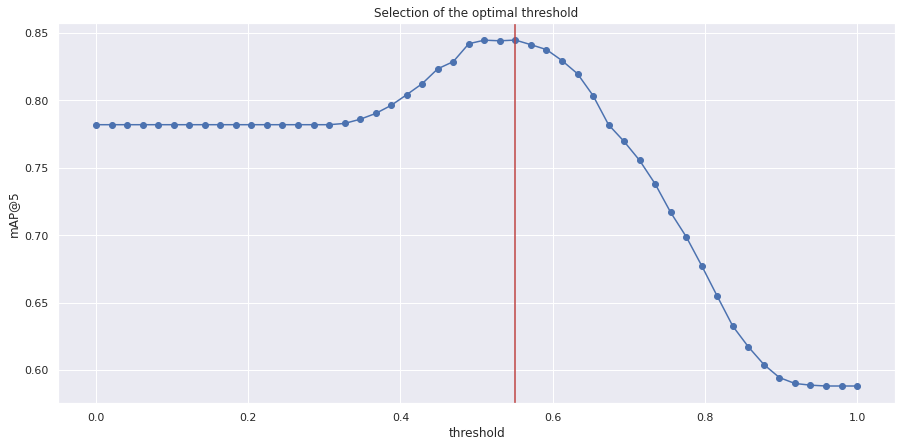

0.5510204081632653 0.8447884094225557


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

x = [ x[0] for x in thresholds_x_map ]
y = [ x[1] for x in thresholds_x_map ]

optimal_threshold = x[np.argmax(y)]
optimal_threshold_map = np.max(y)

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(x, y)
ax.scatter(x,y)
ax.axvline(optimal_threshold, color='#bf4342')
ax.title.set_text('Selection of the optimal threshold')
ax.set_xlabel('threshold')
ax.set_ylabel('mAP@5')
plt.show()
print(optimal_threshold, optimal_threshold_map)

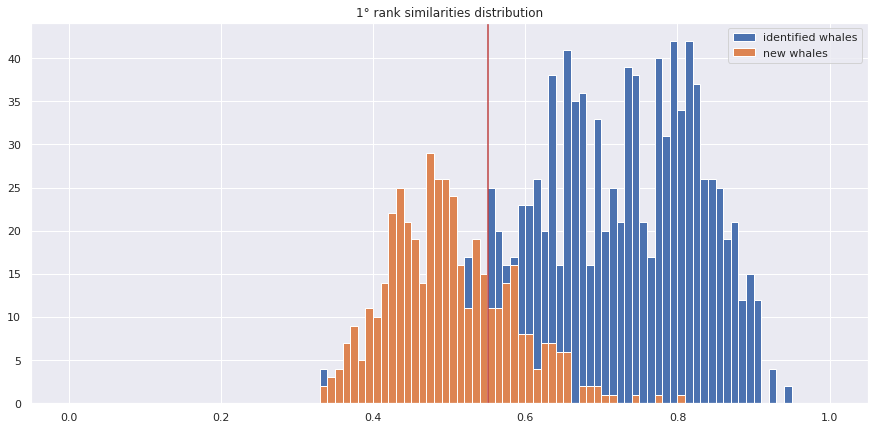

In [94]:
top1_wid = similarities[ whales != -1, 0 ]
top1_new = similarities[ whales == -1, 0 ]

fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(top1_wid, bins=100, range=(0, 1), label='identified whales')
ax.hist(top1_new, bins=100, range=(0, 1), label='new whales')
ax.axvline(optimal_threshold, color='#bf4342')
ax.title.set_text('1° rank similarities distribution')
ax.legend()
plt.show()